In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os 
import math
np.random.seed(1234)

In [60]:
def sigmoid(x):
    return 1/(1+np.exp(-x+0.5))

def psigmoid(x):
    a = sigmoid(x)
    return a*(1 - a)

def ppsigmoid(x):
    a = sigmoid(x)
    return a - 3*a**2 + 2*a**3

def LeapFct(X,sets,coefs):
    p_sets = len(sets)
    parities = np.zeros((X.shape[0],p_sets))
    for j in range(p_sets):
        curr = np.ones(X.shape[0])
        for s in range(len(sets[j])):
            curr = curr*X[:,sets[j][s]]
        parities[:,j] = curr*coefs[j]
    return np.sum(parities,axis = 1)/ p_sets

def SquaredLoss(ytest,yhat_test):
    return np.mean((ytest - yhat_test)**2)

def randomRademacher(n,d):
    return 2*np.random.randint(2, size=(n,d))-1

def randomSecondLayer(N):
    return np.random.uniform(-1,1,N)

In [61]:
def smooth(v,ll):
    if ll == 0:
        return v
    ss = len(v)
    rr = np.copy(v)
    for i in range(ss):
        rr[i] = np.mean(v[max(0,i -ll):min(ss,i+ll)])
    return rr

In [62]:
def loss_train(y,f):
    return (y - f)**2 + (y - f)**3 +(y-f)**4

def loss_derivative(y,f):
    return 2*(y - f) + 3*(y - f)**2 + 4*(y-f)**3

def loss1_train(y,f):
    return (y - f)**2 + np.abs(y - f)**3 

def loss1_derivative(y,f):
    return 2*(y - f) + 3*np.sign(y-f)*(y - f)**2 

def squared_loss(y,f):
    return (y-f)**2

def squared_loss_derivative(y,f):
  return 2*(y-f)

def loss_ellone(y,f):
    return np.abs(y-f)

def loss_ellone_derivative(y,f):
    return np.sign(y-f)

In [63]:
def NNevaluation(W,a,X,N):
    Z = np.matmul(X,W.transpose())
    sigZ = sigmoid(Z)
    return np.matmul(sigZ,a)/N

def EvalError(W,a,mtest,N,P,d,sets,coefs):
    Xtest = randomRademacher(mtest,d)
    ytest = LeapFct(Xtest,sets,coefs)
    yhat_test = NNevaluation(W,a,Xtest,N)
    return SquaredLoss(ytest,yhat_test)

def gradient_sq_loss(W,a,N,mtrain,P,d,sets,coefs):
    Xtrain = randomRademacher(mtrain,d)
    ytrain = LeapFct(Xtrain,sets,coefs)
    Z = np.matmul(W, Xtrain.transpose())
    sigZ = sigmoid(Z)
    psigZ = psigmoid(Z)
    yMF = NNevaluation(W,a,Xtrain,N)
    return [np.matmul(a.reshape(N,1)*psigZ*squared_loss_derivative(ytrain,yMF),Xtrain)/mtrain,np.matmul(sigZ, squared_loss_derivative(ytrain,yMF))/mtrain]

def gradient_ellone_loss(W,a,N,mtrain,P,d,sets,coefs):
    Xtrain = randomRademacher(mtrain,d)
    ytrain = LeapFct(Xtrain,sets,coefs)
    Z = np.matmul(W, Xtrain.transpose())
    sigZ = sigmoid(Z)
    psigZ = psigmoid(Z)
    yMF = NNevaluation(W,a,Xtrain,N)
    return [np.matmul(a.reshape(N,1)*psigZ*loss_ellone_derivative(ytrain,yMF),Xtrain)/mtrain,np.matmul(sigZ, loss_ellone_derivative(ytrain,yMF))/mtrain]

def gradient_loss1(W,a,N,mtrain,P,d,sets,coefs):
    Xtrain = randomRademacher(mtrain,d)
    ytrain = LeapFct(Xtrain,sets,coefs)
    Z = np.matmul(W, Xtrain.transpose())
    sigZ = sigmoid(Z)
    psigZ = psigmoid(Z)
    yMF = NNevaluation(W,a,Xtrain,N)
    return [np.matmul(a.reshape(N,1)*psigZ*loss1_derivative(ytrain,yMF),Xtrain)/mtrain,np.matmul(sigZ, loss1_derivative(ytrain,yMF))/mtrain]


def evaluateFourierCoeff(W,a,N,mtest,P,d,sets,coefs):
    Xtest = randomRademacher(mtest,d)
    yMF = NNevaluation(W,a,Xtest,N)
    p_sets = len(sets)
    parities = np.zeros((mtest,p_sets))
    for j in range(p_sets):
        curr = np.ones(mtest)
        for s in range(len(sets[j])):
            curr = curr*Xtest[:,sets[j][s]]
        parities[:,j] = curr/coefs[j]
    return np.matmul(parities.transpose(),yMF)/mtest

In [64]:
def createXtot(P):
    Xtot = np.zeros((2**P,P))
    for i in range(2**P):
        Xtot[i,:] = np.array(list(np.binary_repr(i, width=P)))
    return 2*Xtot-1

In [65]:
def pexMSPEvalError(U,a,s,Xtot,mG,Nu,P,d,sets,coefs):
    ytest = LeapFct(Xtot,sets,coefs)
    yhat_test = pexMSPNNevaluation(U,a,s,Xtot,2**P,Nu,mG)
    return SquaredLoss(ytest,yhat_test)

def pexMSPNNevaluation(U,a,s,Xtot,mx,Nu,mG):
    G = np.random.normal(0,1,mG)
    Z = np.matmul(Xtot,U.transpose()).reshape(mx,Nu,1) + s.reshape(1,Nu,1)*(np.zeros((mx,Nu,1)) + G.reshape(1,1,mG))
    sigZ = np.mean(sigmoid(Z),axis=2)
    return np.matmul(sigZ,a)/Nu

def pexMSPgradientloss(U,a,s,Xtot,mG,Nu,P,d,sets,coefs):
    G = np.random.normal(0,1,mG)
    ytrain = LeapFct(Xtot,sets,coefs)
    Z = np.matmul(Xtot,U.transpose()).reshape(2**P,Nu,1) + s.reshape(1,Nu,1)*(np.zeros((2**P,Nu,1)) + G.reshape(1,1,mG))
    sigZ = np.mean(sigmoid(Z),axis=2).transpose()
    psigZ = np.mean(psigmoid(Z),axis=2).transpose()
    psigZ2 = np.mean(psigmoid(Z)*G.reshape(1,1,mG),axis=2).transpose()
    yMF = pexMSPNNevaluation(U,a,s,Xtot,2**P,Nu,mG)
    return [np.matmul(a.reshape(Nu,1)*psigZ*loss_derivative(ytrain,yMF),Xtot)/2**P,np.matmul(sigZ,loss_derivative(ytrain,yMF))/2**P,a*np.matmul(psigZ2, loss_derivative(ytrain,yMF))/2**P]

def pexMSPgradientsqloss(U,a,s,Xtot,mG,Nu,P,d,sets,coefs):
    G = np.random.normal(0,1,mG)
    ytrain = LeapFct(Xtot,sets,coefs)
    Z = np.matmul(Xtot,U.transpose()).reshape(2**P,Nu,1) + s.reshape(1,Nu,1)*(np.zeros((2**P,Nu,1)) + G.reshape(1,1,mG))
    sigZ = np.mean(sigmoid(Z),axis=2).transpose()
    psigZ = np.mean(psigmoid(Z),axis=2).transpose()
    psigZ2 = np.mean(psigmoid(Z)*G.reshape(1,1,mG),axis=2).transpose()
    yMF = pexMSPNNevaluation(U,a,s,Xtot,2**P,Nu,mG)
    return [np.matmul(a.reshape(Nu,1)*psigZ*squared_loss_derivative(ytrain,yMF),Xtot)/2**P,np.matmul(sigZ,squared_loss_derivative(ytrain,yMF))/2**P,a*np.matmul(psigZ2, squared_loss_derivative(ytrain,yMF))/2**P]

def pexMSPgradientloss1(U,a,s,Xtot,mG,Nu,P,d,sets,coefs):
    G = np.random.normal(0,1,mG)
    ytrain = LeapFct(Xtot,sets,coefs)
    Z = np.matmul(Xtot,U.transpose()).reshape(2**P,Nu,1) + s.reshape(1,Nu,1)*(np.zeros((2**P,Nu,1)) + G.reshape(1,1,mG))
    sigZ = np.mean(sigmoid(Z),axis=2).transpose()
    psigZ = np.mean(psigmoid(Z),axis=2).transpose()
    psigZ2 = np.mean(psigmoid(Z)*G.reshape(1,1,mG),axis=2).transpose()
    yMF = pexMSPNNevaluation(U,a,s,Xtot,2**P,Nu,mG)
    return [np.matmul(a.reshape(Nu,1)*psigZ*loss1_derivative(ytrain,yMF),Xtot)/2**P,np.matmul(sigZ,loss1_derivative(ytrain,yMF))/2**P,a*np.matmul(psigZ2, loss1_derivative(ytrain,yMF))/2**P]

def pexMSPgradientlossellone(U,a,s,Xtot,mG,Nu,P,d,sets,coefs):
    G = np.random.normal(0,1,mG)
    ytrain = LeapFct(Xtot,sets,coefs)
    Z = np.matmul(Xtot,U.transpose()).reshape(2**P,Nu,1) + s.reshape(1,Nu,1)*(np.zeros((2**P,Nu,1)) + G.reshape(1,1,mG))
    sigZ = np.mean(sigmoid(Z),axis=2).transpose()
    psigZ = np.mean(psigmoid(Z),axis=2).transpose()
    psigZ2 = np.mean(psigmoid(Z)*G.reshape(1,1,mG),axis=2).transpose()
    yMF = pexMSPNNevaluation(U,a,s,Xtot,2**P,Nu,mG)
    return [np.matmul(a.reshape(Nu,1)*psigZ*loss_ellone_derivative(ytrain,yMF),Xtot)/2**P,np.matmul(sigZ,loss_ellone_derivative(ytrain,yMF))/2**P,a*np.matmul(psigZ2, loss_ellone_derivative(ytrain,yMF))/2**P]

def pexMSPevaluateFourierCoeff(U,a,s,Xtot,mG,Nu,P,sets,coefs):
    yMF = pexMSPNNevaluation(U,a,s,Xtot,2**P,Nu,mG)
    p_sets = len(sets)
    parities = np.zeros((2**P,p_sets))
    for j in range(p_sets):
        curr = np.ones(2**P)
        for s in range(len(sets[j])):
            curr = curr*Xtot[:,sets[j][s]]
        parities[:,j] = curr/coefs[j]
    return np.matmul(parities.transpose(),yMF)/2**P

In [66]:
P = 4
uuu = [[1,2,3],[0,2,3],[0,1,3],[0,1,2]]
ccc=np.random.uniform(-2,2,len(uuu))
print(ccc)
mmm = len(uuu)
KK=10
T=4000

[-1.2339222   0.48843508 -0.24908904  1.14143433]


In [67]:

d = 100

xi = 0.5
eta_w =  xi
eta_a =  xi

Xtot = createXtot(P)
Nu = 50
mG = 100
    
N = 300
mtest = 300
mtrain = d

TrackLossDF11 = np.zeros((KK,T))
TrackFourierDF11 = np.zeros((KK,T,mmm))

TrackLossSGD11 = np.zeros((KK,T))
TrackFourierSGD11 = np.zeros((KK,T,mmm))

for kk in range(KK):
    
    at_DF = randomSecondLayer(Nu)
    Ut_DF = 0*randomRademacher(Nu,P)/np.sqrt(d)
    st_DF = np.ones(Nu)

    at_SGD = randomSecondLayer(N)
    Wt_SGD = randomRademacher(N,d)/np.sqrt(d)

    for t in range(T):
        TrackLossSGD11[kk,t] = EvalError(Wt_SGD,at_SGD,mtest,N,P,d,uuu,ccc)
        [GW,Ga] = gradient_sq_loss(Wt_SGD,at_SGD,N,mtrain,P,d,uuu,ccc)
        Wt_SGD = Wt_SGD + eta_w*GW
        at_SGD = at_SGD + eta_a*Ga
        
        TrackLossDF11[kk,t] = pexMSPEvalError(Ut_DF,at_DF,st_DF,Xtot,mG,Nu,P,d,uuu,ccc)
        [GUDF,GaDF,GsDF] = pexMSPgradientsqloss(Ut_DF,at_DF,st_DF,Xtot,mG,Nu,P,d,uuu,ccc)
        Ut_DF = Ut_DF + eta_w*GUDF
        at_DF = at_DF + eta_a*GaDF
        st_DF = st_DF + eta_w*GsDF
        if t%500==0:
         print(kk,t, TrackLossDF11[kk,t], TrackLossSGD11[kk,t])

0 0 0.19541712235657352 0.20766236877122027
0 500 0.19537815724890872 0.17649790988135422
0 1000 0.19537815726203103 0.032355323070181734
0 1500 0.19537815725294502 0.00016561112378264928
0 2000 0.1953781572531818 1.2392560295734099e-05
0 2500 0.1953781572585334 4.5469218126473834e-06
0 3000 0.19537815729418856 3.3875379265058704e-06
0 3500 0.19537815727327687 2.569589819647882e-06
1 0 0.19558689742954233 0.1848392068607833
1 500 0.19537815784196133 0.1964273616239564
1 1000 0.19537815725222218 0.1186122138342824
1 1500 0.1953781572494102 0.0026068017569876437
1 2000 0.1953781572539789 3.701549907981422e-05
1 2500 0.1953781572517636 1.1801427734393253e-05
1 3000 0.19537815725677352 5.804660115980847e-06
1 3500 0.19537815758771337 4.159822649590224e-06
2 0 0.20341352358004894 0.20600593359282632
2 500 0.19537816726204874 0.19796958146566562
2 1000 0.19537816439045416 0.05336569182029951
2 1500 0.19537815724834776 7.50059009709556e-05
2 2000 0.19537816418454476 6.424681373616555e-06
2 25

In [68]:
d = 300

xi = 0.5
eta_w =  xi
eta_a =  xi

Xtot = createXtot(P)
Nu = 50
mG = 100
    
N = 300
mtest = 300
mtrain = d

TrackLossDF12 = np.zeros((KK,T))
TrackLossSGD12 = np.zeros((KK,T))

for kk in range(KK):
    
    at_DF = randomSecondLayer(Nu)
    Ut_DF = 0*randomRademacher(Nu,P)/np.sqrt(d)
    st_DF = np.ones(Nu)

    at_SGD = randomSecondLayer(N)
    Wt_SGD = randomRademacher(N,d)/np.sqrt(d)

    for t in range(T):
        TrackLossSGD12[kk,t] = EvalError(Wt_SGD,at_SGD,mtest,N,P,d,uuu,ccc)
        [GW,Ga] = gradient_sq_loss(Wt_SGD,at_SGD,N,mtrain,P,d,uuu,ccc)
        Wt_SGD = Wt_SGD + eta_w*GW
        at_SGD = at_SGD + eta_a*Ga
        
        TrackLossDF12[kk,t] = pexMSPEvalError(Ut_DF,at_DF,st_DF,Xtot,mG,Nu,P,d,uuu,ccc)
        [GUDF,GaDF,GsDF] = pexMSPgradientsqloss(Ut_DF,at_DF,st_DF,Xtot,mG,Nu,P,d,uuu,ccc)
        Ut_DF = Ut_DF + eta_w*GUDF
        at_DF = at_DF + eta_a*GaDF
        st_DF = st_DF + eta_w*GsDF
        if t%500 == 0:
         print(kk,t,TrackLossDF12[kk,t], TrackLossSGD12[kk,t])

0 0 0.19610037455539842 0.18807461254809643
0 500 0.19537815822838986 0.20769784455652948
0 1000 0.19537815753746685 0.17259660507041802
0 1500 0.19537815906338793 0.18698603853050544
0 2000 0.19537815744754355 0.15871189337212394
0 2500 0.1953781587501522 0.10077949856703787
0 3000 0.19537815734230213 0.001506402632138693
0 3500 0.19537815746051224 2.791230265402391e-05
1 0 0.19697996074235438 0.18192389195552008
1 500 0.19537815724844812 0.19598570784272445
1 1000 0.19537815925334817 0.1953331392890283
1 1500 0.1953781572503857 0.19037225330815422
1 2000 0.19537815742813605 0.20348676726699555
1 2500 0.19537816027575672 0.19284766789674837
1 3000 0.1953781588351543 0.18264837253495703
1 3500 0.1953781579730451 0.16122566935876706
2 0 0.19543525452401522 0.21932301051939437
2 500 0.19537815726384947 0.20157309628703987
2 1000 0.1953781572481628 0.2010373642404857
2 1500 0.19537815725655183 0.18818415439742886
2 2000 0.19537815725251612 0.1562791601168362
2 2500 0.19537815727938102 0.0

In [69]:

d = 500
np.random.seed(10)
xi = 0.5
eta_w =  xi
eta_a =  xi

Xtot = createXtot(P)
Nu = 50
mG = 100
    
N = 300
mtest = 300
mtrain = d


TrackLossDF13 = np.zeros((KK,T))

TrackLossSGD13 = np.zeros((KK,T))

for kk in range(KK):
    
    at_DF = randomSecondLayer(Nu)
    Ut_DF = 0*randomRademacher(Nu,P)/np.sqrt(d)
    st_DF = np.ones(Nu)

    at_SGD = randomSecondLayer(N)
    Wt_SGD = randomRademacher(N,d)/np.sqrt(d)

    for t in range(T):
        TrackLossSGD13[kk,t] = EvalError(Wt_SGD,at_SGD,mtest,N,P,d,uuu,ccc)
    
        [GW,Ga] = gradient_sq_loss(Wt_SGD,at_SGD,N,mtrain,P,d,uuu,ccc)
        Wt_SGD = Wt_SGD + eta_w*GW
        at_SGD = at_SGD + eta_a*Ga
        
        TrackLossDF13[kk,t] = pexMSPEvalError(Ut_DF,at_DF,st_DF,Xtot,mG,Nu,P,d,uuu,ccc)
    
        [GUDF,GaDF,GsDF] = pexMSPgradientsqloss(Ut_DF,at_DF,st_DF,Xtot,mG,Nu,P,d,uuu,ccc)
        Ut_DF = Ut_DF + eta_w*GUDF
        at_DF = at_DF + eta_a*GaDF
        st_DF = st_DF + eta_w*GsDF
        if t%500 == 0:
         print(kk,t,TrackLossDF13[kk,t], TrackLossSGD13[kk,t])

0 0 0.19538015399145792 0.18785730769836054
0 500 0.19537815725307428 0.1976570245007617
0 1000 0.19537815724815066 0.1785967198104425
0 1500 0.1953781572479566 0.19458974563286421
0 2000 0.1953781572480241 0.18180771976983515
0 2500 0.1953781572491699 0.18393085653677502
0 3000 0.19537815724976504 0.1985074388111101
0 3500 0.19537815725326083 0.1899022509537553
1 0 0.19540403050407232 0.19697252960175055
1 500 0.19537815727621408 0.19438804603224352
1 1000 0.19537815725205882 0.19726104202272954
1 1500 0.19537815724965069 0.17036103517911635
1 2000 0.19537815728759786 0.1918503315425719
1 2500 0.19537815724788177 0.1550877778873688
1 3000 0.19537815730011487 0.015427054194884438
1 3500 0.19537815725207636 9.065288488240936e-05
2 0 0.19563184449638335 0.19094132975060948
2 500 0.19537815741161546 0.20908869509364147
2 1000 0.19537815740013065 0.20036500720741485
2 1500 0.1953781572554652 0.1997361702570406
2 2000 0.19537815734851854 0.15746364983747316
2 2500 0.1953781572570079 0.21532

In [70]:
meanLossDF11 = np.mean(TrackLossDF11,axis = 0)

meanLoss11 = np.mean(TrackLossSGD11,axis = 0)
stdLoss11 = np.std(TrackLossSGD11,axis = 0)/np.sqrt(KK)

In [71]:
meanLossDF12 =  np.mean(TrackLossDF12,axis = 0)

meanLoss12 = np.mean(TrackLossSGD12,axis = 0)
stdLoss12 = np.std(TrackLossSGD12,axis = 0)/np.sqrt(KK)

In [72]:
meanLossDF13 = np.mean(TrackLossDF13,axis = 0)
meanLoss13 = np.mean(TrackLossSGD13,axis = 0)
stdLoss13 = np.std(TrackLossSGD13,axis = 0)/np.sqrt(KK)

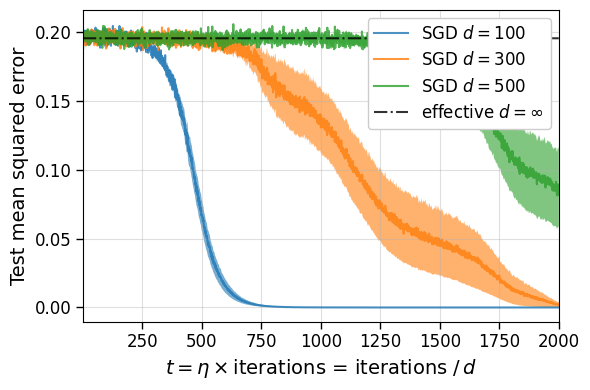

In [73]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))#, gridspec_kw={'width_ratios': [1.5, 2]})


ax.plot(xi*np.arange(T),smooth(meanLoss11,1), linestyle='-', alpha = 0.8, label=r'SGD $d=100$')
ax.fill_between(xi*np.arange(T),smooth(meanLoss11 - stdLoss11,4), smooth(meanLoss11 + stdLoss11,4),  alpha = 0.6)

ax.plot(xi*np.arange(T),smooth(meanLoss12,1), linestyle='-', alpha = 0.8, label=r'SGD $d=300$')
ax.fill_between(xi*np.arange(T),smooth(meanLoss12 - stdLoss12,4), smooth(meanLoss12 + stdLoss12,4),  alpha = 0.6)


ax.plot(xi*np.arange(T),smooth(meanLoss13,1), linestyle='-', alpha = 0.8, label=r'SGD $d=500$')
ax.fill_between(xi*np.arange(T),smooth(meanLoss13 - stdLoss13,4), smooth(meanLoss13 + stdLoss13,4),  alpha = 0.6)


   
ax.plot(xi*np.arange(T),smooth(meanLossDF11,5), color ='black', alpha = 0.8,linestyle='-.', label='effective $d=\infty$')


ax.set_xlabel(r'$t= \eta \times $iterations = iterations $/\,d$', fontsize =14)
ax.set_ylabel(r'Test mean squared error', fontsize =14)
plt.setp(ax.get_xticklabels(),fontsize=12)
plt.setp(ax.get_yticklabels(),fontsize=12)
ax.tick_params(direction='out', length=5, width=1)
ax.set_yticks([0.2,0.15,0.10,0.05,0.00], major=True)
ax.grid(alpha=0.4)
ax.legend(loc='upper right', fontsize=12, framealpha = 1)
ax.set_xlim([3,xi*T])

fig.tight_layout()
plt.savefig('ell2loss/ell2leap1.pdf')
plt.show()

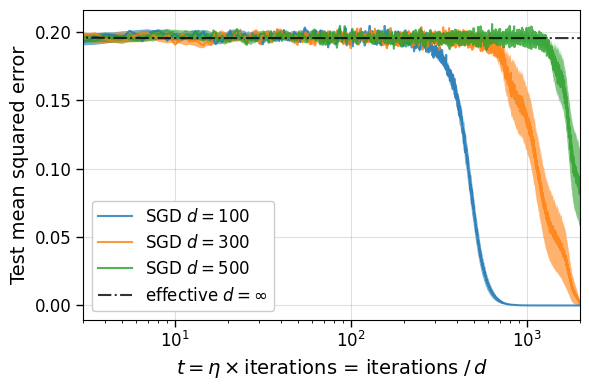

In [75]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))#, gridspec_kw={'width_ratios': [1.5, 2]})

ax.plot(xi*np.arange(T),smooth(meanLoss11,1), linestyle='-', alpha = 0.8, label=r'SGD $d=100$')
ax.fill_between(xi*np.arange(T),smooth(meanLoss11 - stdLoss11,4), smooth(meanLoss11 + stdLoss11,4),  alpha = 0.6)

ax.plot(xi*np.arange(T),smooth(meanLoss12,1), linestyle='-', alpha = 0.8, label=r'SGD $d=300$')
ax.fill_between(xi*np.arange(T),smooth(meanLoss12 - stdLoss12,4), smooth(meanLoss12 + stdLoss12,4),  alpha = 0.6)


ax.plot(xi*np.arange(T),smooth(meanLoss13,1), linestyle='-', alpha = 0.8, label=r'SGD $d=500$')
ax.fill_between(xi*np.arange(T),smooth(meanLoss13 - stdLoss13,4), smooth(meanLoss13 + stdLoss13,4),  alpha = 0.6)


   
ax.plot(xi*np.arange(T),smooth(meanLossDF11,5), color ='black', alpha = 0.8,linestyle='-.', label='effective $d=\infty$')


ax.grid(alpha=0.4)
ax.set_xlabel(r'$t= \eta \times $iterations = iterations $/\,d$', fontsize =14)
ax.set_ylabel(r'Test mean squared error', fontsize =14)
plt.setp(ax.get_xticklabels(),fontsize=12)
plt.setp(ax.get_yticklabels(),fontsize=12)
ax.tick_params(direction='out', length=5, width=1)
ax.legend(loc='lower left', fontsize=12, framealpha = 1)
ax.set_xscale('log')
ax.set_xlim([3,xi*T])

fig.tight_layout()
plt.savefig('ell2loss/ell2leap1-log.pdf')
plt.show()